### RGMA GPM + feature labels product
- some example figures demosntrating the overlapping rainfall from multiple features
- associated statistics

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from itertools import combinations

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
RGMA_DIR = Path('/neelin2020/RGMA_feature_mask/data_product/2017/MERGED_FP')
MERGE_DIR = Path('/neelin2020/RGMA_feature_mask/MERGE-IR/2017/')

In [4]:
def coordinates_processors(data):
    """
    converting longitude/latitude into lon/lat
    data: xarray.dataset coordinated horizontally in lat/lon
    """

    coord_names = []
    for coord_name in data.coords:
        coord_names.append(coord_name)

    if (set(coord_names) & set(['lon','lat'])): # if coordinates set this way...

        data2 = data.rename({'lat': 'latitude'})
        data2 = data2.rename({'lon': 'longitude'})

    else:
        data2 = data

    # check if lon from -180
    if data2.longitude[0] != 0: # -180 to 180

        lon_reset = data2.longitude
        lon_reset = lon_reset.where(lon_reset > 0, 360+lon_reset) # converting lon as 0 to 359.75
        data2.coords['longitude'] = lon_reset # converting lon as -180 to 180
        data2= data2.sortby('longitude')

    # check if latitutde is decreasing
    if (data2.latitude[1] - data2.latitude[0]) < 0:
        data2 = data2.isel(latitude=slice(None, None, -1)) # flipping latitude accoordingly

    return data2

### Stats from here: some test for feature-associated extractioon 



In [5]:
files = sorted(list(RGMA_DIR.glob('*_expand.nc')))
data_FP_merged = xr.open_mfdataset(files, engine='netcdf4')

In [6]:
data_FP_merged['tags_sum'] = (data_FP_merged.ar_tag + data_FP_merged.mcs_tag 
                            + data_FP_merged.lps_tag + data_FP_merged.front_c_tag 
                            + data_FP_merged.front_w_tag + data_FP_merged.front_s_tag)
data_FP_merged = data_FP_merged.sel(latitude=slice(-60,60), longitude=slice(0,359.75))

In [7]:
# assign one tag for all fronts for simplicity: front_a_tag
tmp = data_FP_merged['front_c_tag'] + data_FP_merged['front_w_tag'] + data_FP_merged['front_s_tag']
tmp = tmp.where(tmp == 0, 1)
data_FP_merged['front_a_tag'] = tmp

In [8]:
# generate all the combinations of 4 feature cateogries (AR, front, MCS, LPS)
tag_labels = ['ar_tag','front_a_tag','mcs_tag','lps_tag']

list_of_comb = []
for i in range(1,5): # c41 c42 c43 c44
    tmp = list(combinations(tag_labels, i))
    for j in tmp:
        list_of_comb.append(j)

In [9]:
def generate_FP_data(data_FP_merged, tag_binary_labels):
    """tag_labels: [list of binary labels] features that users are interested. 
       order: ar_tag, front_a_tag, lps_tag, mcs_tag. 
       usage: [1,0,0,1] for AR-MCS cooccurrence
    """
    
    if sum(tag_binary_labels) == 1: # one feature identified, extract the areas of precipitation that may include other features
        
        idx = np.where(np.asarray(tag_binary_labels) == 1)[0][0] 
        if idx == 0:
            precip_FP_selected = data_FP_merged.precipitationCal.where(data_FP_merged.ar_tag == 1)
        if idx == 1:
            precip_FP_selected = data_FP_merged.precipitationCal.where(data_FP_merged.front_a_tag == 1)
        if idx == 2:
            precip_FP_selected = data_FP_merged.precipitationCal.where(data_FP_merged.lps_tag == 1)
        if idx == 3:
            precip_FP_selected = data_FP_merged.precipitationCal.where(data_FP_merged.mcs_tag == 1)
    
    else: # if overlapping exists, extract the overlapped areas of precipitation

        precip_FP_selected = data_FP_merged.precipitationCal.where((data_FP_merged.ar_tag == tag_binary_labels[0]) &
                                                  (data_FP_merged.front_a_tag == tag_binary_labels[1]) &
                                                  (data_FP_merged.lps_tag == tag_binary_labels[2]) &
                                                  (data_FP_merged.mcs_tag == tag_binary_labels[3]))
    
    return precip_FP_selected

In [10]:
# starting with [0, 0, 0, 0] and replaced by 1 if corresponding features are selected

output_list = [] # list of datasets representing different feature selections

for selected_tags in list_of_comb:
    #selected_tags = ['mcs_tag', 'ar_tag']
    tag_binary_labels = [0,0,0,0]
    for i in selected_tags:
        if i == 'ar_tag':
            tag_binary_labels[0] = 1
        if i == 'front_a_tag':
            tag_binary_labels[1] = 1   
        if i == 'lps_tag':
            tag_binary_labels[2] = 1
        if i == 'mcs_tag':
            tag_binary_labels[3] = 1

    output_list.append(generate_FP_data(data_FP_merged, tag_binary_labels))

In [11]:
prec_tot = (data_FP_merged.precipitationCal.sum('time')).fillna(0)

### one feature-associated preciptation showcase in the output_list: MCS-AR

In [ ]:
prec_contr_MCS_AR = (output_list[5].sum('time')).fillna(0) # by looking up the list_of_comb

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='gray')
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

cf = ax.contourf(prec_contr_MCS_AR.longitude, prec_contr_MCS_AR.latitude, prec_contr_MCS_AR, levels=np.linspace(0,50,11), transfrom=ccrs.PlateCarree())
cbar = plt.colorbar(cf, ax=ax, shrink=0.6, pad=0.01)
cbar.set_label('rainfall sum [mm/hr]')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

In [ ]:
%%time
fig, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='gray')
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

cf = ax.contourf(prec_contr_MCS_AR.longitude, prec_contr_MCS_AR.latitude, prec_tot, levels=np.linspace(0,1000,21)
                 , transfrom=ccrs.PlateCarree(), extend='both', cmap='terrain_r')
cbar = plt.colorbar(cf, ax=ax, shrink=0.6, pad=0.01)
cbar.cmap.set_under('w')
cbar.cmap.set_over('b')
cbar.set_label('rainfall sum [mm/hr]')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title('Total precipitation (sum of 6-hrly rainrate), 2017')

In [ ]:
# adding unexplained precipitation for plotting
output_unexplained = generate_FP_data(data_FP_merged, tag_binary_labels=[0,0,0,0])

In [ ]:
list_of_data = [data_FP_merged.precipitationCal] + output_list + [output_unexplained]
list_of_label = [('total',)] + list_of_comb + [('unexplained',)]

In [ ]:
fig, ax = plt.subplots(6,3,figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

ncol = [0,1,2,3,4,5,0,1,2,3,4,5,0,1,2,3,4,5]
nrow = [0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2]
clevels = np.linspace(0,1200,13)

for n, (p_data, p_label) in enumerate(zip(list_of_data, list_of_label)):
    
    ax[ncol[n],nrow[n]].coastlines(color='gray')
    ax[ncol[n],nrow[n]].add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND
    
    cf = ax[ncol[n],nrow[n]].contourf(p_data.longitude, p_data.latitude, p_data.sum('time').fillna(0), 
                                 levels = clevels, cmap='jet', transform=ccrs.PlateCarree())
    cbar = plt.colorbar(cf, ax=ax[ncol[n], nrow[n]], shrink=0.6, pad=0.01)
    
    gl = ax[ncol[n], nrow[n]].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.4, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax[ncol[n], nrow[n]].set_title('{}'.format(p_label),
                fontsize=11)
plt.suptitle('Feature-associated precipitation, 2017', fontsize=11)
plt.tight_layout()

###  statistics from the precipitation contribution

In [16]:
files = sorted(list(RGMA_DIR.glob('*_convmask.nc')))
Feature_comb_xr = xr.open_mfdataset(files)

In [17]:
FID_label = ['AR','FT','MCS','LPS','AF','AM','AL','FM','FL','ML','AFM','AFL','AML','FML','All','UE']

In [20]:
### regional contribution of rainfall from features
### regional feature occurrence in each month

def regional_feature_occurrence(lon_bounds, lat_bounds, area_name):
    
    # region to be analyzed
    prec_sub = data_FP_merged['precipitationCal'].sel(longitude=slice(lon_bounds[0], lon_bounds[1])
                                , latitude=slice(lat_bounds[0], lat_bounds[1])) 
    Feat_ind_sub = Feature_comb_xr['feat_comb_label'].sel(longitude=slice(lon_bounds[0], lon_bounds[1])
                                , latitude=slice(lat_bounds[0], lat_bounds[1])) 
    
    # empty arrays: population, rainfall contribution 
    prec_assocaite_time = []
    prec_contr_time = []
    
    for t in range(len(prec_sub.time)):
        prec_associate = np.zeros(16) # percentage of representative of each feature indicator 
        prec_sum = np.zeros(16) # rainfall contribution from each feature indicator
    
        tmp = prec_sub.isel(time=t)
        tmp2 = Feat_ind_sub.isel(time=t)
        
        Feat_ind_1d = tmp2.values.ravel()
        prec_1d = tmp.values.ravel()
        for idx in range(len(Feat_ind_1d)):
            label_ind = Feat_ind_1d[idx]
            
            prec_associate[label_ind-1] += 1
            prec_sum[label_ind-1] += prec_1d[idx]
        
        prec_assocaite_time.append(prec_associate/np.sum(prec_associate)) 
        prec_contr_time.append(prec_sum/np.sum(prec_sum))
    
    data_xr = xr.Dataset(data_vars=dict(indicator_percentage=(['time', 'feature_indicator'], np.asarray(prec_assocaite_time)),
                                        rainfall_percentage=(['time', 'feature_indicator'], np.asarray(prec_contr_time)),
                                        prec_area_mn=(['time'], prec_sub.mean(dim=('longitude','latitude')).values)),
                         coords=dict(time=(['time'],prec_sub.time.values),
                                     feature_indicator=(['feature_indicator'], np.arange(1,17)),
                                     area=area_name),
                         attrs=dict(description='regional rainfall contribution from each feature indcator.')
                        )
    
    return data_xr
        

In [21]:
def extreme_precip_association(lon_bounds, lat_bounds, area_name):
    
    # extreme 99 percentile
    prec_sub = data_FP_merged['precipitationCal'].sel(longitude=slice(lon_bounds[0], lon_bounds[1])
                                , latitude=slice(lat_bounds[0], lat_bounds[1])) 
    Feat_ind_sub = Feature_comb_xr['feat_comb_label'].sel(longitude=slice(lon_bounds[0], lon_bounds[1])
                                , latitude=slice(lat_bounds[0], lat_bounds[1])) 
    
    
    # find the 99th rainfall extreme
    prec_99th_threshold = np.zeros((prec_sub.shape[1],prec_sub.shape[2]))
    
    for j in range(len(prec_sub.latitude)):
        for i in range(len(prec_sub.longitude)):
            prec_gpt = prec_sub.isel(longitude=i, latitude=j).compute()
            prec_gpt = prec_gpt.where(prec_gpt >0, np.nan) # discard non-raining sampling
            prec_99th_threshold[j,i] = prec_gpt.quantile(q=0.99, dim='time').values
    
    Feat_ind_99th_array = np.zeros((prec_sub.shape[1],prec_sub.shape[2],16)) # (lat,lon,FID)
    # find the corresponding feature indicator
    for j in range(len(prec_sub.latitude)):
        for i in range(len(prec_sub.longitude)):
            prec_gpt = prec_sub.isel(longitude=i, latitude=j).compute()
            Feat_ind_gpt = Feat_ind_sub.isel(longitude=i, latitude=j).compute()
        
            idx_t = np.where(prec_gpt.values > prec_99th_threshold[j,i])[0]
            Feat_list = Feat_ind_gpt.isel(time=idx_t)
            
            Feat_ind_99th = np.zeros(16)
            for fid in Feat_list:
                Feat_ind_99th[fid-1] += 1
                
            Feat_ind_99th_array[j,i,:] = Feat_ind_99th/np.sum(Feat_ind_99th) # percentage
           
        
    Feat_ind_99th_xr = xr.Dataset(data_vars=dict(FID_p99th=(['latitude','longitude','feature_indicator'],
                                                               Feat_ind_99th_array),
                                                 p99th=(['latitude','longitude'], prec_99th_threshold, {'unit':'mm/hr'})),
                                  coords=dict(latitude=(['latitude'],prec_sub.latitude.values),
                                              longitude=(['longitude'],prec_sub.longitude.values),
                                              FID=(['feature_indicator'], np.arange(1,17))),
                                  attrs = {'feature indicator': '(1) AR    (2) Front    (3) MCS    (4) LPS    ' + 
                                     '(5) AR + Front    (6) AR + MCS    (7) AR + LPS    (8) Front + MCS    ' +
                                     '(9) Front + LPS    (10) MCS + LPS    (11): AR + Front + MCS    (12) AR + Front + LPS    ' +
                                     '(13) AR + MCS + LPS    (14) Front + MCS + LPS    (15): All    (16) Unexplained',
                                   
                                    'description': 'Feature-assocaited indicator of a raining pixel. Each indicator is mutually exclusive to one another. ' +
                                                   'For instance, label 1 is the raining pixel that is associated with AR only and label 5 is the pixel '+ 
                                                    'where AR and MCS are overlapped.'})
    
    return Feat_ind_99th_xr          

In [ ]:
NE_UScoast = regional_feature_occurrence(lon_bounds=(360-76,360-70), lat_bounds=(35,41), area_name='NE_UScoast')
NW_UScoast = regional_feature_occurrence(lon_bounds=(360-125,360-115), lat_bounds=(30,50), area_name='NW_UScoast')
Amazon_area = regional_feature_occurrence(lon_bounds=(360-82,360-34), lat_bounds=(-22,12), area_name='Amazon')
MT_area = regional_feature_occurrence(lon_bounds=(95,145), lat_bounds=(-10,10), area_name='Maritime_Conti')

In [ ]:
NE_UScoast_gp_mon = NE_UScoast.groupby('time.month').mean()
NW_UScoast_gp_mon = NW_UScoast.groupby('time.month').mean()
Amazon_area_gp_mon = Amazon_area.groupby('time.month').mean()
MT_area_gp_mon = MT_area.groupby('time.month').mean()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(7,3.5))

cmap_label = plt.get_cmap('tab20b', 16)

for n, (fid,label) in enumerate(zip(np.arange(1,17),FID_label)):

    tmp = NW_UScoast_gp_mon.sel(feature_indicator=fid).rainfall_percentage.to_series()
    if n < 4:
        ax.plot(np.arange(12),tmp,color=cmap_label.colors[n], marker='^', label=label)
    else:
        ax.plot(np.arange(12),tmp,color=cmap_label.colors[n], marker='o', label=label)

ax.legend(fontsize=8, ncols=5, loc='upper right', frameon=False)
ax.set_ylim([-0.01,1])
ax.set_ylabel('Monthly rainfall contribution')
ax.set_xlabel('')
ax.set_xticks(ticks=np.arange(0,12))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']);
ax.grid(linestyle=':',linewidth=0.5)

# add monthly area-averaged precipitation rate 
ax2 = ax.twinx()
tmp2 = NW_UScoast_gp_mon.prec_area_mn.to_series()
ax2.bar(np.arange(0,12), 24*tmp2, alpha=0.2)
ax2.set_ylabel('Area-mean rainrate (mm d$^{-1}$)')
ax2.set_ylim([0,15])

# add title
ax.set_title(str(NW_UScoast_gp_mon.area.values) + '\n' + 
             '(125W,115W,30N,50N)', fontsize=11);        

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(7,3.5))

cmap_label = plt.get_cmap('tab20b', 16)

for n, (fid,label) in enumerate(zip(np.arange(1,17),FID_label)):

    tmp = NE_UScoast_gp_mon.sel(feature_indicator=fid).rainfall_percentage.to_series()
    if n < 4:
        ax.plot(np.arange(12),tmp,color=cmap_label.colors[n], marker='^', label=label)
    else:
        ax.plot(np.arange(12),tmp,color=cmap_label.colors[n], marker='o', label=label)

ax.legend(fontsize=8, ncols=5, loc='upper right', frameon=False)
ax.set_ylim([-0.01,1])
ax.set_ylabel('Monthly rainfall contribution')
ax.set_xlabel('')
ax.set_xticks(ticks=np.arange(0,12))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']);
ax.grid(linestyle=':',linewidth=0.5)

# add monthly area-averaged precipitation rate 
ax2 = ax.twinx()
tmp2 = NE_UScoast_gp_mon.prec_area_mn.to_series()
ax2.bar(np.arange(0,12), 24*tmp2, alpha=0.2)
ax2.set_ylabel('Area-mean rainrate (mm d$^{-1}$)')
ax2.set_ylim([0,15])

# add title
ax.set_title(str(NE_UScoast_gp_mon.area.values) + '\n' + 
             '(76W,70W,35N,41N)', fontsize=11);        

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(7,3.5))

cmap_label = plt.get_cmap('tab20b', 16)

for n, (fid,label) in enumerate(zip(np.arange(1,17),FID_label)):

    tmp = Amazon_area_gp_mon.sel(feature_indicator=fid).rainfall_percentage.to_series()
    if n < 4:
        ax.plot(np.arange(12),tmp,color=cmap_label.colors[n], marker='^', label=label)
    else:
        ax.plot(np.arange(12),tmp,color=cmap_label.colors[n], marker='o', label=label)

ax.legend(fontsize=8, ncols=5, loc='upper right', frameon=False)
ax.set_ylim([-0.01,1])
ax.set_ylabel('Monthly rainfall contribution')
ax.set_xlabel('')
ax.set_xticks(ticks=np.arange(0,12))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']);
ax.grid(linestyle=':',linewidth=0.5)

# add monthly area-averaged precipitation rate 
ax2 = ax.twinx()
tmp2 = Amazon_area_gp_mon.prec_area_mn.to_series()
ax2.bar(np.arange(0,12), 24*tmp2, alpha=0.2)
ax2.set_ylabel('Area-mean rainrate (mm d$^{-1}$)')
ax2.set_ylim([0,15])

# add title
ax.set_title(str(Amazon_area_gp_mon.area.values) + '\n' + 
             '(82W,34W,22S,12N)', fontsize=11);        

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(7,3.5))

cmap_label = plt.get_cmap('tab20b', 16)

for n, (fid,label) in enumerate(zip(np.arange(1,17),FID_label)):

    tmp = MT_area_gp_mon.sel(feature_indicator=fid).rainfall_percentage.to_series()
    if n < 4:
        ax.plot(np.arange(12),tmp,color=cmap_label.colors[n], marker='^', label=label)
    else:
        ax.plot(np.arange(12),tmp,color=cmap_label.colors[n], marker='o', label=label)

ax.legend(fontsize=8, ncols=5, loc='upper right', frameon=False)
ax.set_ylim([-0.01,1])
ax.set_ylabel('Monthly rainfall contribution')
ax.set_xlabel('')
ax.set_xticks(ticks=np.arange(0,12))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']);
ax.grid(linestyle=':',linewidth=0.5)

# add monthly area-averaged precipitation rate 
ax2 = ax.twinx()
tmp2 = MT_area_gp_mon.prec_area_mn.to_series()
ax2.bar(np.arange(0,12), 24*tmp2, alpha=0.2)
ax2.set_ylabel('Area-mean rainrate (mm d$^{-1}$)')
ax2.set_ylim([0,15])

# add title
ax.set_title(str(MT_area_gp_mon.area.values) + '\n' + 
             '(95E,145E,10S,10N)', fontsize=11);        

### which FPID contributes to most extreme precipitation?

In [30]:
%%time
# extreme precipitation contribution
#extreme_NE_UScoast = extreme_precip_association(lon_bounds=(360-80,360-70), lat_bounds=(30,50), area_name='NE_UScoast')
extreme_NW_UScoast = extreme_precip_association(lon_bounds=(360-125,360-115), lat_bounds=(30,50), area_name='NW_UScoast')

CPU times: user 4min 48s, sys: 4min 43s, total: 9min 32s
Wall time: 8min 32s


In [31]:
cmap_label = plt.get_cmap('tab20b', 16)

newcolors = cmap_label(np.linspace(0, 1, 16))
blue = np.array([0, 0, 0.8, 1])
red = np.array([0.8, 0, 0, 1])
green = np.array([0, 0.8, 0, 1])
newcolors[1, :] = blue
newcolors[3, :] = red
newcolors[4, :] = green
newcmp = ListedColormap(newcolors)

In [32]:
FID_maxcontr_map2 = np.zeros((len(extreme_NW_UScoast.latitude), len(extreme_NW_UScoast.longitude)))
contr_mark_map2 = np.copy(FID_maxcontr_map2)

for i in range(len(extreme_NW_UScoast.latitude)):
    for j in range(len(extreme_NW_UScoast.longitude)):

        # return the FID that accounts for most extreme precipitation when it occurred
        idx = np.argmax(extreme_NW_UScoast.isel(latitude=i, longitude=j).FID_p99th.values)
        FID_maxcontr_map2[i,j] = idx+1 # mark FID on the grid point

Text(0.5, 1.0, 'Feature indicator \n 99th extreme rainfall')

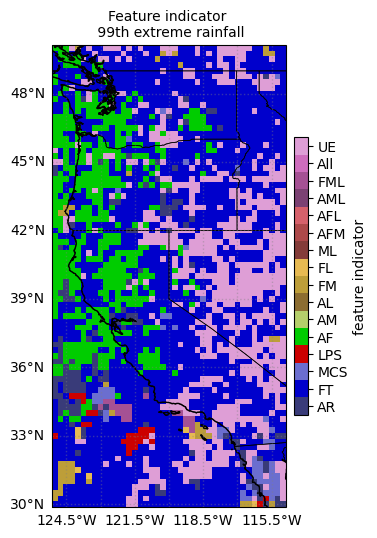

In [33]:
fig, ax = plt.subplots(1,1,figsize=(10,6),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='k')
ax.add_feature(cfeat.STATES,edgecolor='k',linewidth=0.5)
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

cf = ax.pcolormesh(extreme_NW_UScoast.longitude, extreme_NW_UScoast.latitude
                 , FID_maxcontr_map2, vmin=1, vmax=17, cmap=newcmp)
cbar = plt.colorbar(cf, ax=ax, shrink=0.6, pad=0.01)
cbar.set_label('feature indicator')
cbar.set_ticks(np.arange(1.5,17.5,1))
cbar.set_ticklabels(FID_label)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title('Feature indicator \n 99th extreme rainfall',fontsize=10)

In [34]:
%%time
# extreme precipitation contribution
#extreme_NE_UScoast = extreme_precip_association(lon_bounds=(360-80,360-70), lat_bounds=(30,50), area_name='NE_UScoast')
extreme_midlat = extreme_precip_association(lon_bounds=(360-145,360-125), lat_bounds=(30,50), area_name='NW_UScoast')

CPU times: user 9min 37s, sys: 9min 16s, total: 18min 53s
Wall time: 16min 51s


In [35]:
FID_maxcontr_map = np.zeros((len(extreme_midlat.latitude), len(extreme_midlat.longitude)))
contr_mark_map = np.copy(FID_maxcontr_map)

for i in range(len(extreme_midlat.latitude)):
    for j in range(len(extreme_midlat.longitude)):

        # return the FID that accounts for most extreme precipitation when it occurred
        idx = np.argmax(extreme_midlat.isel(latitude=i, longitude=j).FID_p99th.values)
        FID_maxcontr_map[i,j] = idx+1 # mark FID on the grid point

Text(0.5, 1.0, 'Feature indicator \n 99th extreme rainfall')

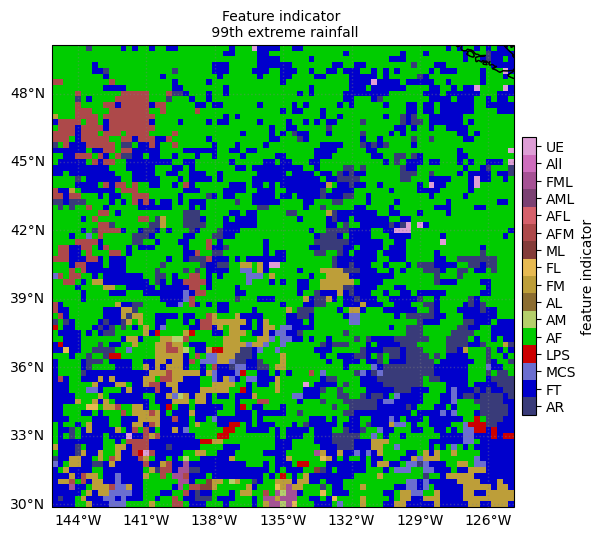

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,6),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='k')
ax.add_feature(cfeat.STATES,edgecolor='k',linewidth=0.5)
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

cf = ax.pcolormesh(extreme_midlat.longitude, extreme_midlat.latitude
                 , FID_maxcontr_map, vmin=1, vmax=17, cmap=newcmp)
cbar = plt.colorbar(cf, ax=ax, shrink=0.6, pad=0.01)
cbar.set_label('feature indicator')
cbar.set_ticks(np.arange(1.5,17.5,1))
cbar.set_ticklabels(FID_label)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title('Feature indicator \n 99th extreme rainfall',fontsize=10)

In [37]:
%%time
extreme_Amazon = extreme_precip_association(lon_bounds=(360-82,360-34), lat_bounds=(-22,12), area_name='Amazon')

CPU times: user 40min 2s, sys: 41min 55s, total: 1h 21min 57s
Wall time: 1h 14min 58s


In [ ]:
FID_maxcontr_map3 = np.zeros((len(extreme_Amazon.latitude), len(extreme_Amazon.longitude)))
contr_mark_map3 = np.copy(FID_maxcontr_map3)

for i in range(len(extreme_Amazon.latitude)):
    for j in range(len(extreme_Amazon.longitude)):

        # return the FID that accounts for most extreme precipitation when it occurred
        idx = np.argmax(extreme_Amazon.isel(latitude=i, longitude=j).FID_p99th.values) # 0-15
        FID_maxcontr_map3[i,j] = idx+1 # mark FID on the grid point, 1-16
        
        # mark if that FID accounts for more than 50% 
        if np.max(extreme_Amazon.isel(latitude=i, longitude=j).FID_p99th.values) >= 0.5:
            contr_mark_map3[i,j] = 1
        # mark if that FID accounts for more than 75%
        elif np.max(extreme_Amazon.isel(latitude=i, longitude=j).FID_p99th.values) >= 0.75:
            contr_mark_map3[i,j] = 2
        else:
            contr_mark_map3[i,j] = 0

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='k')
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

cf = ax.pcolormesh(extreme_Amazon.longitude, extreme_Amazon.latitude
                 , FID_maxcontr_map3, vmin=1, vmax=17, cmap=newcmp)
cbar = plt.colorbar(cf, ax=ax, shrink=0.6, pad=0.01)
cbar.set_label('feature indicator')
cbar.set_ticks(np.arange(1.5,17.5,1))
cbar.set_ticklabels(FID_label)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title('Feature indicator accounting for 99th extreme rainfall \n Amazon (82W-34W, 22S-12N)',fontsize=10)

In [ ]:
extreme_MT = extreme_precip_association(lon_bounds=(95,145), lat_bounds=(-10,10), area_name='Maritime_Conti')

In [ ]:
FID_maxcontr_map4 = np.zeros((len(extreme_MT.latitude), len(extreme_MT.longitude)))
contr_mark_map4 = np.copy(FID_maxcontr_map4)

for i in range(len(extreme_MT.latitude)):
    for j in range(len(extreme_MT.longitude)):

        # return the FID that accounts for most extreme precipitation when it occurred
        idx = np.argmax(extreme_MT.isel(latitude=i, longitude=j).FID_p99th.values)
        FID_maxcontr_map4[i,j] = idx+1 # mark FID on the grid point
        
        # mark if that FID accounts for more than 50% 
        if np.max(extreme_MT.isel(latitude=i, longitude=j).FID_p99th.values) >= 0.5:
            contr_mark_map4[i,j] = 1
        # mark if that FID accounts for more than 75%
        elif np.max(extreme_MT.isel(latitude=i, longitude=j).FID_p99th.values) >= 0.75:
            contr_mark_map4[i,j] = 2
        else:
            contr_mark_map4[i,j] = 0

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='k')
#ax.add_feature(cfeat.STATES,edgecolor='k',linewidth=0.5)
#ax.add_feature(cfeat.RIVERS,edgecolor='b',linewidth=0.5)
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

cf = ax.pcolormesh(extreme_MT.longitude, extreme_MT.latitude
                 , FID_maxcontr_map4, vmin=1, vmax=17, cmap=newcmp)
cbar = plt.colorbar(cf, ax=ax, shrink=0.4, pad=0.01)
cbar.set_label('feature indicator')
cbar.set_ticks(np.arange(1.5,17.5,1))
cbar.set_ticklabels(FID_label)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title('Feature indicator accounting for 99th extreme rainfall \n Maritime (95E-145E, 10S-10N)',fontsize=10)

In [ ]:
# open ocean - should have MCS right?
extreme_INDO = extreme_precip_association(lon_bounds=(60,90), lat_bounds=(-10,10), area_name='Indian Ocean')

In [ ]:
FID_maxcontr_map5 = np.zeros((len(extreme_INDO.latitude), len(extreme_INDO.longitude)))*np.nan
contr_mark_map5 = np.copy(FID_maxcontr_map5)

for i in range(len(extreme_INDO.latitude)):
    for j in range(len(extreme_INDO.longitude)):

        # return the FID that accounts for most extreme precipitation when it occurred
        idx = np.argmax(extreme_INDO.isel(latitude=i, longitude=j).FID_p99th.values)
        FID_maxcontr_map5[i,j] = idx+1 # mark FID on the grid point

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='k')
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

cf = ax.pcolormesh(extreme_INDO.longitude, extreme_INDO.latitude
                 , FID_maxcontr_map5, vmin=1, vmax=17, cmap=newcmp)
cbar = plt.colorbar(cf, ax=ax, shrink=0.4, pad=0.01)
cbar.set_label('feature indicator')
cbar.set_ticks(np.arange(1.5,17.5,1))
cbar.set_ticklabels(FID_label)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title('Feature indicator accounting for 99th extreme rainfall \n Indian Ocean (60E-90E, 10S-10N)',fontsize=10)

### screening out days of extremes and see if MCS really coocurrence with AR over the NW US

In [ ]:
p99th_NWUS = extreme_NW_UScoast.p99th

In [ ]:
prec_NWUS = data_FP_merged.precipitationCal.sel(longitude=slice(360-125,360-115), latitude=slice(30,50))

### case study: Janurary 9th, 2017 CA floods

In [ ]:
Feature_comb_case = Feature_comb_xr.sel(time=slice(datetime(2017,1,8,0), datetime(2017,1,9,0)),
                                        longitude=slice(360-125,360-115), latitude=slice(30,50))
prec_case = data_FP_merged.precipitationCal.sel(time=slice(datetime(2017,1,8,0), datetime(2017,1,9,0)),
                                            longitude=slice(360-125,360-115), latitude=slice(30,50))

In [ ]:
cmap_label = plt.get_cmap('tab20b', 16)

In [ ]:
newcolors = cmap_label(np.linspace(0, 1, 16))
blue = np.array([0, 0, 0.8, 1])
red = np.array([0.8, 0, 0, 1])
newcolors[1, :] = blue
newcolors[3, :] = red
newcmp = ListedColormap(newcolors)

In [ ]:
fig, ax = plt.subplots(1,5,figsize=(15,6), subplot_kw={'projection': ccrs.PlateCarree()})
for t in range(5):
    
    ax[t].coastlines(color='grey')
    ax[t].add_feature(cfeat.STATES,edgecolor='grey',linewidth=0.5)
    ax[t].add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

    tmp = Feature_comb_case.feat_comb_label.isel(time=t)
    tmp = tmp.where(tmp > 0, np.nan)
    
    cp = ax[t].pcolormesh(Feature_comb_case.longitude, Feature_comb_case.latitude,
                        tmp, vmin=1, vmax=17, cmap=newcmp)
    cbar = plt.colorbar(cp, ax=ax[t], shrink=0.5, pad=0.02)
    cbar.set_ticks(np.arange(1.5,17.5,1))
    cbar.set_ticklabels(FID_label)
    
    # add GPM contour
    cf = ax[t].contour(prec_case.longitude, prec_case.latitude,
                        prec_case.isel(time=t), levels=[1,3,5,10,15,20], colors=['k'],
                        linewidths=1)
    ax[t].clabel(cf, cf.levels, inline=True, fontsize=8, colors=['k'])
    
    gl = ax[t].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.4, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    ax[t].set_title(str(prec_case.isel(time=t).time.values)[:-10])

plt.tight_layout()

In [ ]:
Feature_comb_case2 = Feature_comb_xr.sel(time=slice(datetime(2017,1,18,0), datetime(2017,1,19,0)),
                                        longitude=slice(360-125,360-115), latitude=slice(30,50))
prec_case2 = data_FP_merged.precipitationCal.sel(time=slice(datetime(2017,1,18,0), datetime(2017,1,19,0)),
                                            longitude=slice(360-125,360-115), latitude=slice(30,50))

In [ ]:
fig, ax = plt.subplots(1,5,figsize=(15,6), subplot_kw={'projection': ccrs.PlateCarree()})
for t in range(5):
    
    ax[t].coastlines(color='grey')
    ax[t].add_feature(cfeat.STATES,edgecolor='grey',linewidth=0.5)
    ax[t].add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

    tmp = Feature_comb_case2.feat_comb_label.isel(time=t)
    tmp = tmp.where(tmp > 0, np.nan)
    
    cp = ax[t].pcolormesh(Feature_comb_case2.longitude, Feature_comb_case2.latitude,
                        tmp, vmin=1, vmax=17, cmap=newcmp)
    cbar = plt.colorbar(cp, ax=ax[t], shrink=0.5, pad=0.02)
    cbar.set_ticks(np.arange(1.5,17.5,1))
    cbar.set_ticklabels(FID_label)
    
    # add GPM contour
    cf = ax[t].contour(prec_case2.longitude, prec_case2.latitude,
                        prec_case2.isel(time=t), levels=[1,3,5,10,15,20], colors=['k'],
                        linewidths=1)
    ax[t].clabel(cf, cf.levels, inline=True, fontsize=8, colors=['k'])
    
    gl = ax[t].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.4, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    ax[t].set_title(str(prec_case2.isel(time=t).time.values)[:-10])

plt.tight_layout()